# Importing libraries

In [ ]:
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow
import operator

# Code for Cities and Routes and Showing Maps

In [ ]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def coordinate(self):
        return (self.x, self.y)
    
    def __rshift__(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __lshift__(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

class Route(list):
    def __init__(self):
        self.fitness = 0
        self.distance = 0
    
    def __init__(self, list:list):
        self.fitness = 0
        self.distance = 0
        for city in list:
            self.append(city)
    
    def append(self, city: City):
        if super().__len__() != 0: #checking route has some length
            self.distance += super().__getitem__(-1) >> city #finding distance between cities
        super().append(city)
    
    def __getitem__(self, sliced):
        return super().__getitem__(sliced)   # to slice out cities
    
    def __len__(self):
        return super().__len__()
    
    def calculate_fitness(self):
        self.fitness = 1 / float(self.distance)

def show_map(cities, best_route=None, MAP_HEIGHT=500, MAP_WIDTH=500, file_name=None):
    map = np.zeros((MAP_HEIGHT, MAP_WIDTH, 3), np.uint8)
    banner = np.ones((50, MAP_WIDTH, 3), np.uint8) * 255
    map = np.vstack([map, banner])
    for city in cities:
        cv2.circle(map, city.coordinate(), 5, (255,0,0), -1)
    
    if best_route != None: #
        for i in range(0, len(best_route) - 1):
            cv2.line(map, best_route[i].coordinate(), best_route[i+1].coordinate(), (255,255,255), 2, 0)
        cv2.putText(map, 'Distance: {:.1f}'.format(best_route.distance), (0, MAP_HEIGHT+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, 1)

    if file_name != None:
      cv2.imwrite(file_name, map)
    cv2_imshow(map)

# Generating Random Cities

In [ ]:
MAX_CITIES = 30
MAP_HEIGHT, MAP_WIDTH = 500, 500

How to create a city and use it

In [ ]:
# Sample to create and use cities
# create new cities with their coordinates
city1 = City(0,0)
city2 = City(10,10)
city3 = City(5,20)

In [ ]:
# calculate distance between cities
# we can use << or >> to calculate distance between two cities
distance1 = city1 << city2
distance2 = city1 >> city2
print('Distance from {} to {} is {}'.format(city2, city1, distance1))
print('Distance from {} to {} is {}'.format(city1, city2, distance2))

Distance from (10,10) to (0,0) is 14.142135623730951
Distance from (0,0) to (10,10) is 14.142135623730951


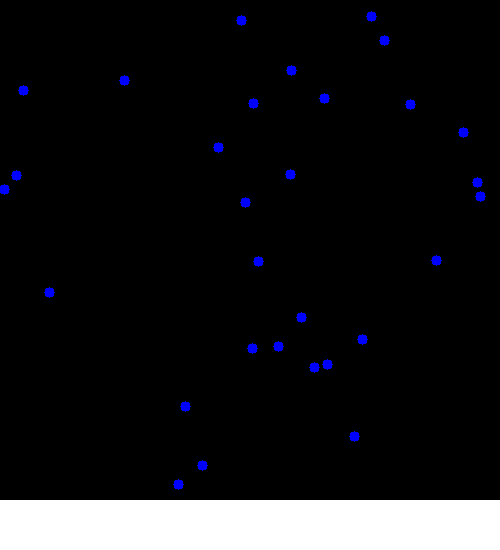

In [ ]:
# Creating random cities within map 
def generate_cities():
    return [ City(random.randrange(0, MAP_WIDTH),random.randrange(0, MAP_HEIGHT)) for _ in range(MAX_CITIES)]

cities = generate_cities()

# function to show map
show_map(cities, MAP_HEIGHT=MAP_HEIGHT, MAP_WIDTH=MAP_WIDTH)

# Generate random generation

How to create Route and use it?

In [ ]:
route = Route([city1, city2, city3])
print(route)

[(0,0), (10,10), (5,20)]


In [ ]:
print('Total distance of route: ', route.distance)

Total distance of route:  25.3224755112299


In [ ]:
# calculate fitness of route
route.calculate_fitness()
print('Fitness of route: ', route.fitness)

Fitness of route:  0.03949060981642669


In [ ]:
GENERATION_SIZE = 500
 
# function to create random generation (random routes)
def first_generation(cities):
    generation = []
    for i in range(0, GENERATION_SIZE):
        # generating random route (random combination of cities)
        route_list = random.sample(cities, len(cities))
        route = Route(route_list)
        # after creating route we need to calculate fitness of the route. It will automatically be stored in route
        route.calculate_fitness()
        generation.append(route)
    
    return generation
new_generation = first_generation(cities)

# Finding best route in current generation

In [ ]:
# function to find best route from generation (best route will have highest fitness)
def get_best_route(generation):
    best_fitness = -1
    best_route = None
    for route in generation:
        if best_fitness < route.fitness:
            best_fitness = route.fitness
            best_route = route
    return best_route
current_best_route = get_best_route(new_generation)

In [ ]:
print('Fitness of current best route: ',current_best_route.fitness)
print('Total distance of current best route: ',current_best_route.distance)

Fitness of current best route:  0.00018363383802564985
Total distance of current best route:  5445.61944983321


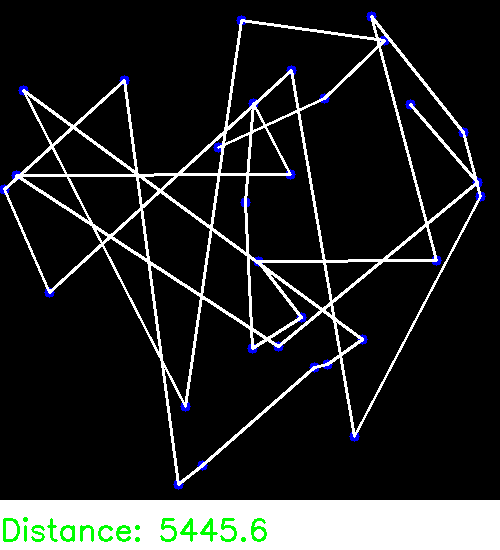

In [ ]:
show_map(cities, MAP_HEIGHT = MAP_HEIGHT, MAP_WIDTH = MAP_WIDTH, best_route = current_best_route, file_name='initial.jpg') 

# Genetic Algorithm

## Selection (Tournament) 

In [ ]:
# function to sort routes based on their fitness score
def rank_generation(generation):
    return sorted(generation, key=operator.attrgetter('fitness'), reverse=True)

In [ ]:
ELITE_SIZE = 50
TOURNAMENT_SIZE = 5

# function to select best routes from generation
# fittest will survive, else will die
def select_generation(ranked_generation):
    selected = [ranked_generation[i] for i in range(ELITE_SIZE)]
    
    for i in range(len(ranked_generation) - ELITE_SIZE):
        # select random 'k' for tournament
        random_k = random.sample(ranked_generation, TOURNAMENT_SIZE)
        # select best among 'k'
        won = max(random_k, key=operator.attrgetter('fitness'))
        selected.append(won)
    return selected

## Crossover

In [ ]:
# function to mate two routes (parents) and generate two children
def mate(parent1, parent2):
    i = random.randint(0, len(parent1)-1)
    j = random.randint(0, len(parent1)-1)
    min_index = min([i, j])
    max_index = max([i, j])
    
    parent1_gene = parent1[min_index:max_index]
    parent2_gene = parent1[min_index:max_index]

    child_one = []
    child_one.extend(parent2_gene)
    child_one.extend([city for city in parent1 if city not in parent2_gene])
    
    child_two = []
    child_two.extend(parent1_gene)
    child_two.extend([city for city in parent2 if city not in parent1_gene])
    
    child_one = Route(child_one)
    child_one.calculate_fitness()
    child_two = Route(child_two)
    child_two.calculate_fitness()    
    return [child_one, child_two]    

# function to perform crossover over whole generation 
# base function to call mate function
def crossover(selection):
    random.shuffle(selection)
    new_generation = []
    for i in range(0, GENERATION_SIZE, 2):
        children = mate(selection[i], selection[i+1])
        new_generation.extend(children)
    return new_generation

## Mutation

In [ ]:
mp = 0.01
child = [1, 2, 3, 4, 5]
random_probability_for_each_value_in_gene = [0.1, 0.02, 0.4, 0.6, 0.9]
"2" 0.02<0.01(mp)
rn = 3
mutated_child = [1, 4, 3, 2, 5]

In [ ]:
MUTATION_RATE = 0.01

# function to mutate individual route
def mutate_individual(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            # perform mutation if random value is smaller than MUTATION_RATE
            random_j = random.randint(0, len(individual)-1)
            # swap cities in route
            city = individual[i]
            individual[i] = individual[random_j]
            individual[random_j] = city
    return individual

# function to perform mutation in whole generation
# base bunction to call mutate_individual
def mutation(crossovered):
    mutated = []
    for individual in crossovered:
        mutated.append(mutate_individual(individual))
    return mutated

In [ ]:
# funtion to generate new generation by 
# 1. ranking routes
# 2. selecting fittest route for mating
# 3. Performing crossover (mating)
# 4. Perform mutaion

def next_generation(current_generation):
    ranked_generation = rank_generation(current_generation)
    selection = select_generation(ranked_generation)
    crossovered = crossover(selection)
    mutated = mutation(crossovered)
    return mutated

# Final

In [ ]:
# Change parameters (if you want)

MAX_CITIES = 30
MAP_HEIGHT, MAP_WIDTH = 500, 500

GENERATION_SIZE = 500
GENERATIONS = 300
ELITE_SIZE = 50
TOURNAMENT_SIZE = 5
MUTATION_RATE = 0.01

In [ ]:
from google.colab import output
from tqdm.notebook import tqdm

In [ ]:
cities = generate_cities()
new_generation = first_generation(cities)
current_best_route = get_best_route(new_generation)
#show_map(cities, MAP_HEIGHT=MAP_HEIGHT, MAP_WIDTH=MAP_WIDTH, best_route=current_best_route, file_name='initial.jpg') 
#output.clear()

best_route = current_best_route
for i in tqdm(range(GENERATIONS), desc = 'Searching suitable solution: '):
    new_generation = next_generation(new_generation) 
    current_best_route = get_best_route(new_generation)
    if current_best_route.fitness > best_route.fitness:
      best_route = current_best_route

Searching suitable solution:   0%|          | 0/300 [00:00<?, ?it/s]

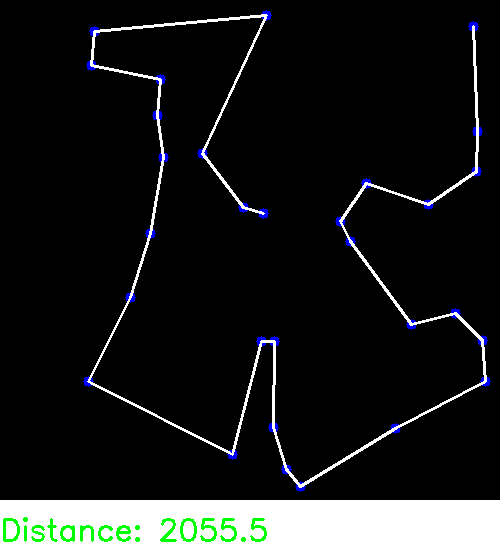

In [ ]:
show_map(cities, MAP_HEIGHT=MAP_HEIGHT, MAP_WIDTH=MAP_WIDTH, best_route=best_route, file_name='best.jpg') 

In [ ]:
Code - https://colab.research.google.com/drive/1edK5fmjk7tFXGgiui6kaxdHEB_dFgZ0i?usp=sharing
Notebook - https://drive.google.com/file/d/1IrW36MxxuWnhZwPcGh1SPZqpcmefpFss/view?usp=sharing
Feedback Link: https://www.techlearn.live/feedback?scheduleId=6117cba1534fa028a5203692

our instagram 👉
http://bit.ly/techlearnlive

our telegram 👉
https://bit.ly/3dYUcDI

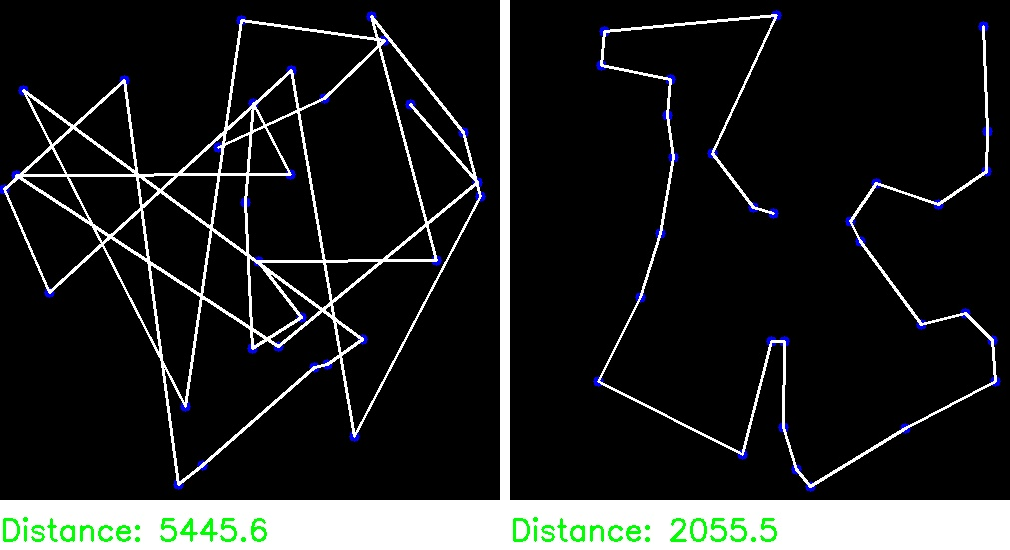

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
initial = cv2.imread('initial.jpg')
line = np.ones((initial.shape[0], 10, 3)) * 255
best = cv2.imread('best.jpg')
image = np.hstack([initial, line, best])
cv2_imshow(image)